<a href="https://colab.research.google.com/github/vishal-n/Face-Detection/blob/master/Unet_myocardium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


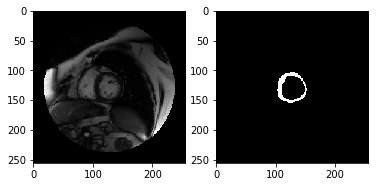

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import backend as K
import cv2
from keras.preprocessing.image import ImageDataGenerator
import pickle
from keras.callbacks import ModelCheckpoint
from skimage import img_as_ubyte

from keras.models import *
from keras.layers import *
from keras.optimizers import *

seed = 5421
np.random.seed(seed)

startDir = '/content/drive/My Drive/Colab Notebooks/'
weights_dir = startDir

mask_train=open("/content/drive/My Drive/Colab Notebooks/mask_train_new.pkl","rb")
mask_train=pickle.load(mask_train)
mask_test=open("/content/drive/My Drive/Colab Notebooks/mask_test_new.pkl","rb")
mask_test=pickle.load(mask_test)
mask_dev=open("/content/drive/My Drive/Colab Notebooks/mask_dev_new.pkl","rb")
mask_dev=pickle.load(mask_dev)
image_train=open("/content/drive/My Drive/Colab Notebooks/image_train_new.pkl","rb")
image_train=pickle.load(image_train)
image_test=open("/content/drive/My Drive/Colab Notebooks/image_test_new.pkl","rb")
image_test=pickle.load(image_test)
image_dev=open("/content/drive/My Drive/Colab Notebooks/image_dev_new.pkl","rb")
image_dev=pickle.load(image_dev)

    
s1 = (300,256,256,1)
s2 = (75,256,256,1)
s3 = (125,256,256,1)
####creating 4D array
im_tr = np.zeros(s1)
ms_tr = np.zeros(s1)
im_vl = np.zeros(s2)
ms_vl = np.zeros(s2)
im_ts = np.zeros(s3)
ms_ts = np.zeros(s3)

for k in range(300):
    im_tr[k,:,:,0] = image_train[:,:,k]/np.max(image_train[:,:,k])
    ms_tr[k,:,:,0] = mask_train[:,:,k]

for k in range(75):    
    im_vl[k,:,:,0] = image_dev[:,:,k] / np.max(image_dev[:,:,k])
    ms_vl[k,:,:,0] = mask_dev[:,:,k]

for k in range(125):
    im_ts[k,:,:,0] = image_test[:,:,k] / np.max(image_test[:,:,k])
    ms_ts[k,:,:,0] = mask_test[:,:,k]





image_train = im_tr
mask_train = ms_tr
image_dev = im_vl
mask_dev = ms_vl
image_test = im_ts
mask_test = ms_ts


plt.subplot(121)
img1=plt.imshow(image_dev[1,:,:,0],cmap='gray')
plt.subplot(122)
img2=plt.imshow(mask_dev[1,:,:,0],cmap='gray')

In [0]:
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
  
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
 
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)
  
def dice_loss(smooth):
  def dice(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
  return dice

def dice_mon(smooth):
  def dicemon(y_true, y_pred):
    return dice_coef(y_true, y_pred, smooth=smooth)
  return dicemon

def jaccard_mon(smooth):
  def jaccardmon(y_true, y_pred):
    return jaccard_coef(y_true, y_pred, smooth=smooth)
  return jaccardmon




def conv_block(layer_before, features, block_no = 0, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform', pool_bool = True):
  if pool_bool:
    block = '_convblock_'+str(block_no)
  else:
    block = '_middleblock'
  conv = Conv2D(features, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv1'+block)(layer_before)
  conv = BatchNormalization()(conv)
  conv = Conv2D(features, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv2'+block)(conv)
  conv = BatchNormalization()(conv)
  if pool_bool:
    conv = MaxPooling2D(pool_size=(2, 2), name = 'pool'+block)(conv)
  return conv
def deconv_block(layer_before, features, block_no = 0, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform'):
  if block_no == 0:
    conv = Conv2D(2, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer)(layer_before)
    return conv
  block = '_deconvblock_'+str(block_no)
  up = UpSampling2D(size = (2,2), name = 'up'+block)(layer_before)
  conv = Conv2D(features, 2, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv1'+block)(up)
  conv = BatchNormalization()(conv)
  conv = Conv2D(features, 3, activation = activation, padding = padding, kernel_initializer = kernel_initializer, name = 'conv2'+block)(conv)
  conv = BatchNormalization()(conv)
  return conv

def encoder(input_layer, starting_features = 64, depth=4):
  conv_d=[]
  conv = input_layer
  features = starting_features
  for i in range(depth):
    conv = conv_block(conv,features, block_no=i+1)
    conv_d.append(conv)
    features *= 2
  return conv, features, conv_d

def middle_layer(input_conv, features):
  return conv_block(input_conv, features, pool_bool=False)

def decoder(input_conv, depth_conv, features=1024, height=4):
  conv = input_conv
  conv_d = depth_conv
  features = int(features/2)
  for i in range(height):
    conv = concatenate([conv, conv_d[3 - i]],axis=-1)
    conv = deconv_block(conv,features, block_no=i+1)
    features = int(features/2)
  conv = deconv_block(conv,features,block_no=0)
  return conv

def build_model(input_size = (256,256,1), depth = 4):
  inputs = Input(input_size)
  conv, features, conv_d = encoder(inputs, depth=depth)
  
  middle_conv = middle_layer(conv,features)
  conv = decoder(middle_conv, conv_d, features = features, height = depth)
  out = Conv2D(1, 1, activation = 'sigmoid')(conv)

  model = Model(inputs = inputs, outputs = out)

  return model

In [0]:
def compile_model(depth = 4): 
  model = build_model(depth=depth)
  smooth=K.epsilon()
  model_dice = dice_loss(smooth=smooth)
  dicemon = dice_mon(smooth)
  jaccardmon = jaccard_mon(smooth)
  sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
  model.compile(optimizer = sgd, loss = model_dice, metrics = [dicemon, jaccardmon])  # Adam(lr = 1e-4),
  return model


kwargs = dict(
        rotation_range=180,
        zoom_range=0.0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )

image_datagen = ImageDataGenerator(**kwargs)
mask_datagen = ImageDataGenerator(**kwargs)
val_image_datagen = ImageDataGenerator(**kwargs)
val_mask_datagen = ImageDataGenerator(**kwargs)

mini_batch_size = 8

image_generator = image_datagen.flow(image_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator = mask_datagen.flow(mask_train, shuffle=False,
                                batch_size=mini_batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)

val_image_generator = val_image_datagen.flow(image_dev, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
val_mask_generator = val_mask_datagen.flow(mask_dev, shuffle=False,
                                batch_size=mini_batch_size, seed=seed)
val_generator = zip(val_image_generator, val_mask_generator)



model = compile_model(depth = 4)
pre_load = True 


# if preload weights
if pre_load:
  model_name = '_unet_donut' 
  epoch_count = 5   #15  # which ealier model weights are to be loaded
  saved_weights_file = weights_dir + 'sunnybrook'+model_name+'-{:02d}.hdf5'.format(epoch_count) 
  model.load_weights(saved_weights_file)
  
  
model_name = '_unet_donut' 
weights_file = weights_dir + 'sunnybrook'+model_name+'-{epoch:02d}.hdf5' 
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_dicemon',verbose=1, period=5)  

if pre_load:
  ie = epoch_count
  pre_load = True
else:
  ie = 0
epochs = ie + 4
hist = model.fit_generator(train_generator,steps_per_epoch=1000,epochs=epochs,callbacks=[model_checkpoint], validation_data=val_generator, validation_steps=200, initial_epoch=ie)

W0804 07:31:16.007402 139747466782592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 07:31:16.045071 139747466782592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 07:31:16.055542 139747466782592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 07:31:16.095918 139747466782592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0804 07:31:16.096803 1397474667

Epoch 6/9
1000/1000 [==============================] - 692s 692ms/step - loss: 0.1986 - dicemon: 0.8014 - jaccardmon: 0.6765 - val_loss: 0.4695 - val_dicemon: 0.5305 - val_jaccardmon: 0.4056
Epoch 7/9
1000/1000 [==============================] - 682s 682ms/step - loss: 0.1802 - dicemon: 0.8198 - jaccardmon: 0.6995 - val_loss: 0.4355 - val_dicemon: 0.5645 - val_jaccardmon: 0.4388
Epoch 8/9
1000/1000 [==============================] - 682s 682ms/step - loss: 0.1682 - dicemon: 0.8318 - jaccardmon: 0.7163 - val_loss: 0.8475 - val_dicemon: 0.1525 - val_jaccardmon: 0.1035
Epoch 9/9
1000/1000 [==============================] - 682s 682ms/step - loss: 0.1595 - dicemon: 0.8405 - jaccardmon: 0.7285 - val_loss: 0.3670 - val_dicemon: 0.6330 - val_jaccardmon: 0.4988


In [0]:
model.save(weights_dir + 'sunnybrook'+model_name+'-{:02d}.hdf5'.format(9))

In [0]:
model_p = build_model(depth=4)
epoch_count = 9
model_name = '_unet_donut'
weights_file = weights_dir + 'sunnybrook'+model_name+'-{:02d}.hdf5'.format(epoch_count) 
model_p.load_weights(weights_file)

W0807 04:01:44.000475 140026686465920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 04:01:44.035976 140026686465920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 04:01:44.044881 140026686465920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 04:01:44.084914 140026686465920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 04:01:44.086241 1400266864

In [0]:
pred_masks = model_p.predict(image_test, batch_size=4, verbose=1)
dev_masks = model_p.predict(image_dev, batch_size=4, verbose=1)
fit_masks = model_p.predict(image_train, batch_size=4, verbose=1)

300/300 [==============================] - 8s 28ms/step


0.849852188374045


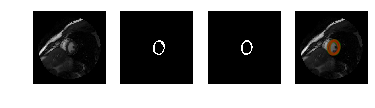

In [0]:
k=14
plt.subplot(141)
img1=plt.imshow(image_test[k,:,:,0],cmap='gray');plt.axis('off')
plt.subplot(142)
img2=plt.imshow(mask_test[k,:,:,0],cmap='gray');plt.axis('off')
plt.subplot(143)
img3=plt.imshow(pred_masks[k,:,:,0],cmap='gray');plt.axis('off')
plt.subplot(144)
img1=plt.imshow(image_test[k,:,:,0],cmap='gray');plt.axis('off')
plt.contour(mask_test[k,:,:,0], levels=(1), colors='green', alpha=0.5)
plt.contour(pred_masks[k,:,:,0], levels=(1), colors='red', alpha=0.5)
dice=2*np.sum(mask_test[k,:,:,0]*pred_masks[k,:,:,0])/(np.sum(mask_test[k,:,:,0])+np.sum(pred_masks[k,:,:,0]))
print(dice)

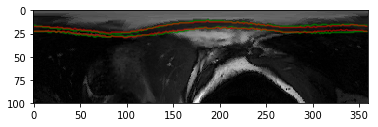

In [0]:
import math
s=(100,360)
img_pol=np.zeros(s)
msk_pol=np.zeros(s)
msk_pol_pred=np.zeros(s)
img=image_test[k,:,:,0]
msk=mask_test[k,:,:,0]
msk_p=pred_masks[k,:,:,0]
ind=np.where(msk == 1)
cy=np.mean(ind[0][:])
cx=np.mean(ind[1][:])
for i in range(100):
  for j in range(360):
    xx=int(i*math.cos(math.pi*j/180)+cx)
    yy=int(i*math.sin(math.pi*j/180)+cy)
    img_pol[i,j]=img[yy,xx]
    msk_pol[i,j]=msk[yy,xx]
    msk_pol_pred[i,j]=msk_p[yy,xx]
    
    
img1=plt.imshow(img_pol,cmap='gray')#;plt.axis('off')
plt.contour(msk_pol, levels=(1), colors='green', alpha=0.5)
plt.contour(msk_pol_pred, levels=(1), colors='red', alpha=0.5)







0.7412304902915139

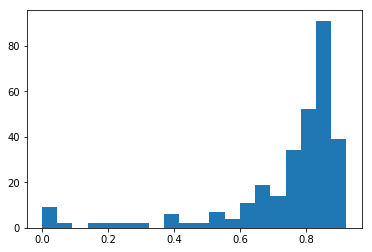

In [0]:
import numpy as np
dice_val=np.zeros(300)
for i in range(300):
    mask = np.where(fit_masks[i,:,:,0]>0.5, 1.0, 0.0)
    dice_val[i]=2*np.sum(mask_train[i,:,:,0]*mask)/(np.sum(mask_train[i,:,:,0])+np.sum(mask))
plt.hist(dice_val, bins=20)
np.mean(dice_val)

0.5879607939871494

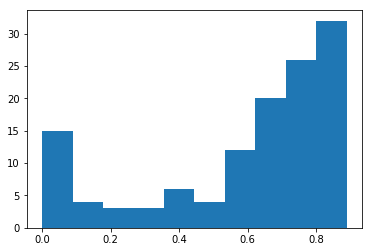

In [0]:
import numpy as np
dice_val=np.zeros(125)
for i in range(125):
  mask = np.where(pred_masks[i,:,:,0]>0.5, 1.0, 0.0)
  dice_val[i]=2*np.sum(mask_test[i,:,:,0]*mask)/(np.sum(mask_test[i,:,:,0])+np.sum(mask))
plt.hist(dice_val, bins=10)
np.mean(dice_val)